In [97]:
import numpy as np
import tensorflow as tf 
import tensorflow_datasets as tfds  
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SDG, RMSProp
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import itertools
import matplotlib.pyplot as plt 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
directory = "C:/Users/Amakapc.LAPTOP-1UBS8G8S/Documents/Data Science CU/Artificial Neural Network/CourseWork/Blood Classification datasets/images"
image_size = 224

In [4]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                            shear_range = 0.2,
                                                            zoom_range = 0.2,
                                                            width_shift_range = 0.2,
                                                            height_shift_range = 0.2,
                                                            fill_mode="nearest")
batch_size = 32
train_data = train_datagen.flow_from_directory(os.path.join(directory,"train"),
                                               target_size=(image_size,image_size),
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode="categorical",                                                                shuffle=True
                                              )

Found 8657 images belonging to 4 classes.


In [5]:
valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)
valid_data = valid_datagen.flow_from_directory(os.path.join(directory,"valid"),
                                               target_size=(image_size,image_size),
                                               batch_size=batch_size,
                                               class_mode="categorical",                                                               shuffle=True
                                              )

Found 1371 images belonging to 4 classes.


In [6]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)
test_data = test_datagen.flow_from_directory(os.path.join(directory,"test"),
                                               target_size=(image_size,image_size),
                                               batch_size=batch_size,
                                               class_mode="categorical",                                                               shuffle=False
                                              )

Found 2487 images belonging to 4 classes.


In [7]:
categories = list(train_data.class_indices.keys())
print(categories)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [8]:
train_data.image_shape
valid_data.image_shape
test_data.image_shape

(224, 224, 3)

In [9]:
mobile = keras.applications.MobileNet(weights="imagenet",include_top=False,input_shape=(image_size,image_size,3))

In [10]:
mobile.trainable = False
inputs = keras.Input(shape=(image_size,image_size,3))
x = mobile(inputs,training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(len(categories),activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=x,name="WhiteBloodCellClassification_MobileNet")

In [21]:
model.summary()

Model: "WhiteBloodCellClassification_MobileNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)             

In [11]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=5) # stops after 5 rounds of no improvements
# optimizer = keras.optimizers.Adam()
# model.compile(optimizer=optimizer,loss=keras.losses.CategoricalCrossentropy(from_logits=True),metrics=[keras.metrics.CategoricalAccuracy()])
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
step_size_train=train_data.n//train_data.batch_size

In [13]:

history = model.fit_generator(train_data,
          validation_data=valid_data,
          epochs=10,
          steps_per_epoch=step_size_train,
          #validation_steps=100,
          callbacks = early_stopping
         )

C:\Users\Amakapc.LAPTOP-1UBS8G8S\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/10
270/270 [==============================] - 419s 2s/step - loss: 1.4505 - accuracy: 0.3822 - val_loss: 0.7901 - val_accuracy: 0.6980
Epoch 2/10
270/270 [==============================] - 416s 2s/step - loss: 0.9399 - accuracy: 0.6045 - val_loss: 0.6690 - val_accuracy: 0.7615
Epoch 3/10
270/270 [==============================] - 411s 2s/step - loss: 0.8066 - accuracy: 0.6719 - val_loss: 0.5299 - val_accuracy: 0.8104
Epoch 4/10
270/270 [==============================] - 417s 2s/step - loss: 0.7464 - accuracy: 0.6891 - val_loss: 0.4836 - val_accuracy: 0.8133
Epoch 5/10
270/270 [==============================] - 419s 2s/step - loss: 0.7028 - accur

In [14]:
model.evaluate(test_data)

78/78 [==============================] - 95s 1s/step - loss: 1.4738 - accuracy: 0.5324


[1.4738142490386963, 0.5323683023452759]

In [15]:
model.save('WhiteBloodCellClassificationmobileNet-cnn.h5')

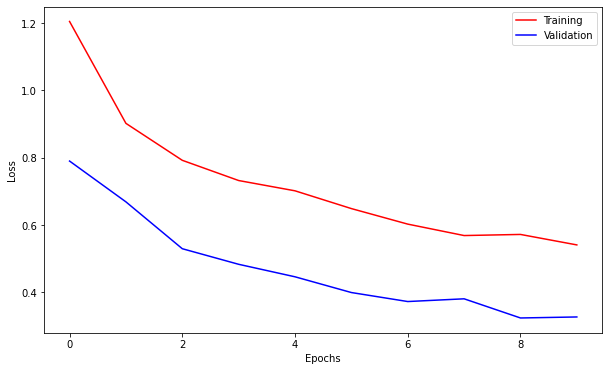

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

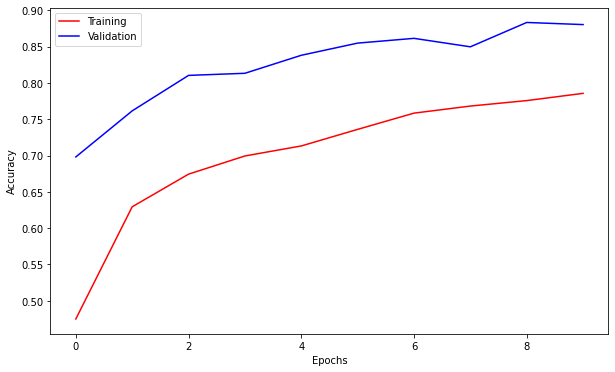

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [85]:
imgs, labels = next(train_data)

In [86]:
# the function will plot images in the form of a grid with 1 row and 10 columns  where images are placed 
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 20, figsize = (15,15))
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


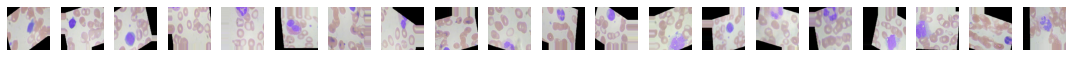

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [87]:
plotImages(imgs)
print(labels)

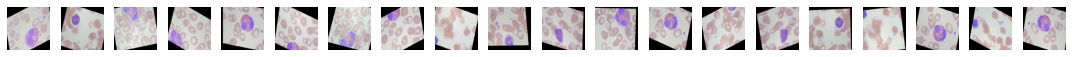

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [63]:
#predicting our model
imgs, labels = next(test_data)
plotImages(imgs)
print(labels)

In [65]:
test_data.classes

array([0, 0, 0, ..., 3, 3, 3])

In [67]:
predictions = model.predict(x = test_data, verbose=0)

In [68]:
np.round(predictions)

array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [69]:

cm=confusion_matrix(y_true=test_data.classes, y_pred=np.argmax(predictions, axis=-1))

In [81]:
def plot_confusion_matrix(cm, classes,
                       Normalise=False,
                       title='White Blood Cell Classification Confusion Matrix',
                       cmap=plt.cm.Blues):
                 plt.imshow(cm, interpolation='nearest', cmap=cmap)
                 plt.title(title)
                 plt.colorbar()
                 tick_marks=np.arange(len(classes))
                 plt.xticks(tick_marks, classes, rotation=45)
                 plt.yticks(tick_marks, classes)
                    

In [82]:
test_data.class_indices

{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

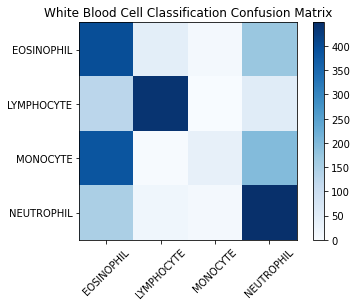

In [83]:
cm_plot_labels=["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]
plot_confusion_matrix(cm=cm, classes = cm_plot_labels, title='White Blood Cell Classification Confusion Matrix')

USING VGG16

In [93]:
model1 = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3), weights='imagenet', include_top= False)

In [94]:
# don't train existing weights
for layer in model1.layers:
    layer.trainable = False

In [95]:
model1.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [102]:
model1=Sequential()

# First Conv block
model1.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (image_size,image_size,3)))
model1.add(Conv2D(16 , (3,3), padding = 'same' , activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))

# Second Conv block
model1.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model1.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

# Third Conv block
model1.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

# Forth Conv block
model1.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))

# Fifth Conv block 
model1.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model1.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))


# FC layer 
model1.add(Flatten())
model1.add(Dense(units = 512 , activation = 'relu'))
model1.add(Dropout(0.7))
model1.add(Dense(units = 128 , activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(units = 64 , activation = 'relu'))
model1.add(Dropout(0.3))

# Output layer
model1.add(Dense(units = 4 , activation = 'softmax'))


In [103]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 32)       

In [110]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=5) # stops after 5 rounds of no improvements
# optimizer = keras.optimizers.Adam()
# model.compile(optimizer=optimizer,loss=keras.losses.CategoricalCrossentropy(from_logits=True),metrics=[keras.metrics.CategoricalAccuracy()])
model1.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [111]:
history1 = model1.fit(x=train_data,
          validation_data=valid_data,
          epochs=10,
         # steps_per_epoch=step_size_train,
          callbacks = early_stopping
          )

Epoch 1/10
271/271 [==============================] - 1548s 6s/step - loss: 4.2308 - accuracy: 0.2531 - val_loss: 1.4065 - val_accuracy: 0.2232
Epoch 2/10
271/271 [==============================] - 1485s 5s/step - loss: 1.3867 - accuracy: 0.2361 - val_loss: 1.3858 - val_accuracy: 0.2502
Epoch 3/10
271/271 [==============================] - 1346s 5s/step - loss: 1.3865 - accuracy: 0.2500 - val_loss: 1.3862 - val_accuracy: 0.2750
Epoch 4/10
271/271 [==============================] - 1350s 5s/step - loss: 1.3865 - accuracy: 0.2484 - val_loss: 1.3855 - val_accuracy: 0.2786
Epoch 5/10
271/271 [==============================] - 3142s 12s/step - loss: 1.3880 - accuracy: 0.2549 - val_loss: 1.4264 - val_accuracy: 0.2378
Epoch 6/10
271/271 [==============================] - 1452s 5s/step - loss: 1.3922 - accuracy: 0.2556 - val_loss: 1.3862 - val_accuracy: 0.2429
Epoch 7/10
271/271 [==============================] - 1420s 5s/step - loss: 1.3865 - accuracy: 0.2512 - val_loss: 1.3862 - val_accuracy

In [112]:
model1.evaluate(test_data)

78/78 [==============================] - 92s 1s/step - loss: 1.3863 - accuracy: 0.2517


[1.3862802982330322, 0.25170889496803284]

In [127]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history1["loss"])
plt.plot(history1["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history1["accuracy"])
plt.plot(history1["val_accuracy"])

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Sequential'

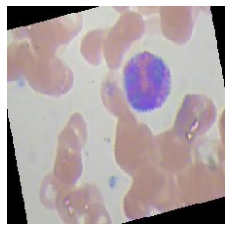

True label: EOSINOPHIL
Predicted label: EOSINOPHIL


In [125]:
def get_class_string_from_index(index):
   for class_string, class_index in test_data.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(test_data)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))



In [128]:
saved_model_path = "VGG16.Classification"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: VGG16.Classification\assets


In [131]:
pred = model1.predict(x=test_data, verbose=0)

In [129]:
cm1=confusion_matrix(y_true=test_data.classes, y_pred=np.argmax(predictions, axis=-1))

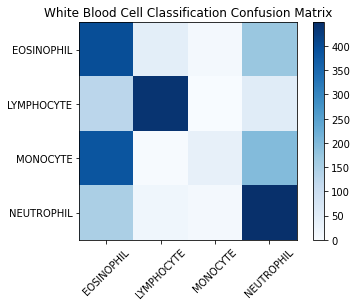

In [130]:
cm_plot_labels=["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]
plot_confusion_matrix(cm=cm, classes = cm_plot_labels, title='White Blood Cell Classification Confusion Matrix')

USING CNN

In [141]:
model2 = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
        MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
        BatchNormalization(),
   

        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2, padding='same'),
        BatchNormalization(),
        Dropout(0.25),

        Flatten(),

        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.25),

        BatchNormalization(),
        Dense(units=4, activation='softmax')
])

In [142]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 56, 56, 64)        256       
_________________________________________________________________
dropout_25 (Dropout)         (None, 56, 56, 64)       

In [146]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=5) # stops after 5 rounds of no improvements
# optimizer = keras.optimizers.Adam()
# model.compile(optimizer=optimizer,loss=keras.losses.CategoricalCrossentropy(from_logits=True),metrics=[keras.metrics.CategoricalAccuracy()])
model2.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [145]:
history2 = model2.fit(x=train_data,
          validation_data=valid_data,
          epochs=5,
         # steps_per_epoch=step_size_train,
          callbacks = early_stopping
          ).history 

Epoch 1/5
271/271 [==============================] - 1153s 4s/step - loss: 0.1980 - accuracy: 0.9236 - val_loss: 0.1224 - val_accuracy: 0.9533
Epoch 2/5
271/271 [==============================] - 1042s 4s/step - loss: 0.1973 - accuracy: 0.9250 - val_loss: 2.3105 - val_accuracy: 0.6411
Epoch 3/5
271/271 [==============================] - 1162s 4s/step - loss: 0.1746 - accuracy: 0.9344 - val_loss: 0.5160 - val_accuracy: 0.8461
Epoch 4/5
271/271 [==============================] - 1184s 4s/step - loss: 0.1824 - accuracy: 0.9314 - val_loss: 1.2325 - val_accuracy: 0.6864
Epoch 5/5
271/271 [==============================] - 1332s 5s/step - loss: 0.1706 - accuracy: 0.9336 - val_loss: 0.9696 - val_accuracy: 0.7425
